In [1]:
#List of all the imports necessary for the notebook
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import sklearn as sk
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Data
The dataset used for our project is imported here. We have used the Davidson Hate Speech Dataset. 

In [3]:
#Adjust the string accordingly to where the data set is saved
#Here the dataset is loaded and assigned to a variable
df = pd.read_csv("../labeled_data.csv")

The structure of the imported data can be seen in the following cell.

The dataset selected for training contains 7 columns and 24.783 rows of data. Hereby are the text passages differentiated into 3 different classes: hate_speech, offensive_language or neither. This classification was conducted by volunteers of CrowdFlower. The predominant predicted class is stored in the column "class". 

In [4]:
#Getting a first overview of the data
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Analysis and Preprocessing
In the following cells we get a rough overview of the data and prepare it in order to make the Tweets analyzable for the later classifiers. 

In [5]:
#Amount of Hate Speech Tweets
len(df[df["class"] == 0])

1430

In [6]:
#Amount of Offensive Tweets
len(df[df["class"] == 1])

19190

In [7]:
#Amount of Neither Tweets
len(df[df["class"] == 2])

4163

In [8]:
#This shows a huge imbalance of examples for each class. The offensive class 
#makes up more than 75% of all Tweets. Following is the neither class and only a few Hate Speech Tweets
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

## Tokenizer

In order to process the data later on, all Tweets are tokenized. This transforms the Tweet into a list of single words contained in the original Tweet.

The Tweets are stored in the dataframe df (column "tweet")

In [9]:
#Split String for each word
def toLowerAndSplit(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    return tweet

The method defined splits every word and moves it to lower cases, so the individual words contained within the Tweet become individualy analyzable.

In [10]:
tweets = pd.DataFrame(df["tweet"].apply(toLowerAndSplit))

In [11]:
#Getting an overview of the single words within each Tweet
#Simultaneously proofing that the transformation was successful 
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"


## Visual Overview

In order to gain deeper insights of the used dataset, we counted the number of times a specific word is present in the observed Tweets.

In [12]:
#Create a list containing all words mentioned in Tweets
all_words = list(itertools.chain(*tweets["tweet"]))

## Count Words

In [13]:
# Count of every word
word_counts = Counter(all_words)

df_uncleaned = pd.DataFrame(word_counts.most_common(10))

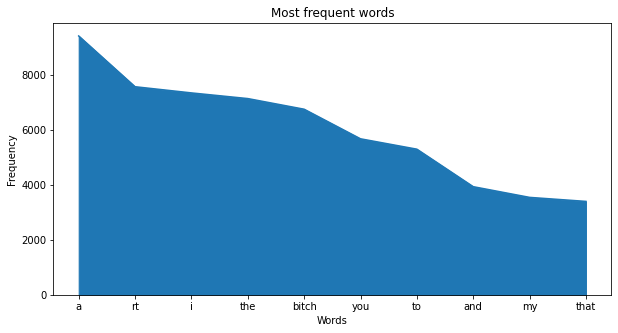

In [14]:
df_uncleaned.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_uncleaned.index)), df_uncleaned[0])
plt.show()

This graph is showing the most used words in the Tweets of the dataset. It is noticeable, that many of the most frequent words are stopwords like "a", "i" or "the", which are not important for our further analysis.

## Remove Stopwords
To gain a more substantial insight into the data, these stopwords have to be removed. These words construct the grammatical dependencies of the english language, but do not contain any relevant information to determine hate speech.

## Remove Tags
Twitter tags such as @genericUser do not give further insight for hate speech detection purposes. Thus, they have to be removed as well.

## Remove Links
Similar to stopwords and Tags, links do not add meaningful information to the purpose of hate speech and will be removed. 

## Remove Twitter Elements
Tweets can contain Twitter excluvsive information, such as "rt", "rts" or "retweet". These formulations do not add any meaning to the Tweets content and therefore have to be removed.

In [15]:
#Downloads list with stopwords of the english language
#Uncomment if nltk stopwords were not downloaded yet
#nltk.download('stopwords')

In [16]:
#Define variable with english stopwords
sw = stopwords.words("english")
twitter_elements = ["rt", "rts", "retweet"]
i_elements = ["i", "i'm", "im", "iam"]
most_common = word_counts.most_common()


#Clean most frequent words by removing unwanted words for visualisation
def removeNoiseWordCount(word_list):
    cleaned_word_list = []
    for element in word_list:
        #Removes words contained in stopwords
        if element[0] not in sw:
            #Removes words with @ --> remove Tags
            if "@" not in element[0]: 
                #Removes words containing http --> links
                if "http" not in element[0]:
                    hasTwitterElement = False
                    hasIElement = False
                    for tw in twitter_elements:
                        if tw in element:
                            hasTwitterElement = True
                    for ie in i_elements:
                        if ie in element:
                            hasIElement = True
                    if hasTwitterElement == False and hasIElement == False:
                        cleaned_word_list.append(element)

    return cleaned_word_list

In [17]:
cleaned_word_list_complete = removeNoiseWordCount(most_common)

In [18]:
df_cleaned_top10 = pd.DataFrame(cleaned_word_list_complete[:10])

In [19]:
df_cleaned_top10

,0,1
0,bitch,6749
1,bitches,2677
2,like,2674
3,hoes,1977
4,pussy,1731
5,hoe,1483
6,ass,1472
7,get,1413
8,fuck,1311
9,got,1275


The list above shows the most frequently used words within the Tweets, after the removal of the Stopwords, Twitter Elements etc.. 

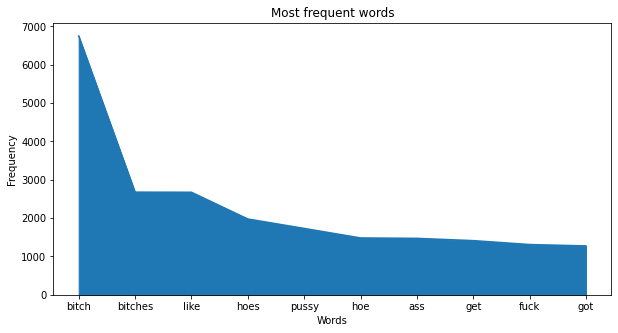

In [20]:
df_cleaned_top10.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_cleaned_top10.index)), df_cleaned_top10[0])
plt.show()

It is noticeable, that certain words appear both in a singualar as well as in their plural form (for example bitch and bitches / hoe and hoes). This could impare the results of our models later on. To counter this, word stems have to be extracted for each word after the data was preprocessed.  

Here the Tweets themselfes, instead of just the single words, are preprocessed in a similar fashion compared to our visualisation efforts. Since the data structure is slightly different, we opted to design a new function.

In [21]:
def removeNoiseFromTweet(word_list):
    cleaned_word_list = []
    for element in word_list:
        for word in element:
            #Removes words contained in stopwords
            if word not in sw:
                #Removes words with @ --> remove Tags
                if "@" not in word: 
                    #Removes words containing http --> links
                    if "http" not in word:
                        hasTwitterElement = False
                        hasIElement = False
                        #Removes Twitter exclusive Words (retweet/ rt...) 
                        for tw in twitter_elements:
                            if tw in word:
                                hasTwitterElement = True
                        for ie in i_elements:
                            if ie in word:
                                hasIElement = True
                        if hasTwitterElement == False & hasIElement == False:
                            #Remove special characters from string
                            cleaned_word = ""
                            cleaned_word = "".join(character for character in word if character.isalnum())
                            
                            if cleaned_word != "":
                                if cleaned_word == "":
                                    print("cleaned_word")
                                cleaned_word_list.append(cleaned_word)
        return cleaned_word_list

In [22]:
#Apply the removeNoiseFromTweet function with axis = 1 --> compute for every row
cleaned_words_df = tweets.apply(func=removeNoiseFromTweet, axis=1)

In [23]:
#Cleaned pandas series element 
cleaned_words_df

0        [woman, complain, cleaning, house, amp, man, a...
1        [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2           [dawg, ever, fuck, bitch, cry, confused, shit]
3                                     [look, like, tranny]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [yous, muthafin, lie, right, tl, trash, 8230, ...
24779    [gone, broke, wrong, baby, drove, redneck, crazy]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781             [youu, got, wild, bitches, tellin, lies]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

The data frame above shows the cleaned individual Tweets, instead of the single word lists from before. These will later be used for the training of the individual classifiers.

## Word Stems

To ensure high data quality, we extract the word stems for each word as described above.(e.g. in plot above: bitch / bitches currently are seperate entities at this point). 

In [24]:
#Downloads list with word stems of words in the english language
#Remove comment when running the first time or not downloaded so far
#nltk.download('punkt')

In [25]:
stemmer = PorterStemmer()
def stemWords(tweet):
    word_stems = []
    for word in tweet:
        
        word_stems.append(stemmer.stem(word))
        
    return word_stems

In [26]:
word_stems = cleaned_words_df.apply(stemWords)

Words contained in the Tweets now only appear with their word stem. This can be seen in the output below.

In [27]:
word_stems

0        [woman, complain, clean, hous, amp, man, alway...
1        [boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...
2             [dawg, ever, fuck, bitch, cri, confus, shit]
3                                     [look, like, tranni]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [you, muthafin, lie, right, tl, trash, 8230, n...
24779    [gone, broke, wrong, babi, drove, redneck, crazi]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781                [youu, got, wild, bitch, tellin, lie]
24782    [ruffl, ntac, eileen, dahlia, beauti, color, c...
Length: 24783, dtype: object

To visualise this effect, we again opted to plot the data to see the differences more clearly.

In [28]:
#Create a list containing all words mentioned in Tweets
stem_words = list(itertools.chain(*word_stems))

In [29]:
#Count of every word
word_counts_stem = Counter(stem_words)

df_stem = pd.DataFrame(word_counts_stem.most_common(10))


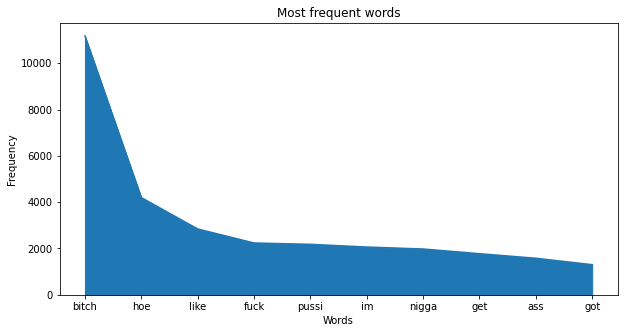

In [30]:
df_stem.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_stem.index)), df_stem[0])
plt.show()

## Word Count for Hate speech
Here we compare the average length of Hate / Offensive / Neither Tweets to gain further insight of the data. Possibly there are connections between the average length of a Tweet and its type. 

In [31]:
#The Tweets of the different classes are assigned to a variable and subsequently
#transformed to their word stems to analyse them correctly
index_hate = df[df["class"] == 0]["tweet"].index
index_offensive = df[df["class"] == 1]["tweet"].index
index_neither = df[df["class"] == 2]["tweet"].index


hate_tweets = word_stems.iloc[index_hate]
offensive_tweets = word_stems.iloc[index_offensive]
neither_tweets = word_stems.iloc[index_neither]

In [32]:
#The function counts the length (amount of words) of each Tweet
#and calculates the average of it
def calculateLength(data):
    data_length = len(data)
    length_count = 0
    for element in data:
        length_count = length_count + len(element)
        
    result = length_count/data_length
    return result
    
length_hate = calculateLength(hate_tweets)
length_offensive = calculateLength(offensive_tweets)
length_neither = calculateLength(neither_tweets)

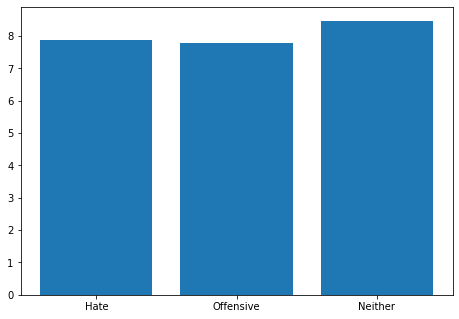

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ["Hate", "Offensive", "Neither"]
length = [length_hate, length_offensive, length_neither]
ax.bar(categories,length)

plt.show()

As can be seen in the graph above, the average length of the Tweets from all classes is around 8 words. Thus, according to the Tweets within the data set, their is not connection between the length of a Tweet and its type. 

# Classifiers

Following different kinds of classifiers are tested for hate speech detection. However before that, the data has to be transformed to be usable for them. 

## Data Preparation

Before the data has been cleaned and preprocessed, so it can be used correctly and visualised to get some insights into the data. In the following, the data is split into Train and Test sets and made usable for the classifiers.

In [34]:
#Change elements of column from list to string
def makeString(column):
    result = " ".join(column)
    return result

In [35]:
word_stems_text = word_stems.apply(makeString)

In [36]:
#Split into train and test set, with distribution of 80%/20% for training set
X_train, X_test, y_train, y_test = train_test_split(word_stems_text, df["class"], test_size=0.2, random_state=10)

In [37]:
#Calculation of custom weights, because of the class imbalance. Gives a higher weight to underrepresented classes 
#compared to the classes with more samples
custom_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
print(custom_weights)

[5.77176128 0.42983198 1.99899173]


In [38]:
#The following function creates a dictionary with the customized weights
def custom_weights_to_dictionary(weights):
    dic = {}
    for i in range(len(weights)):
        dic[i] = weights[i]
    return dic

weights = custom_weights_to_dictionary(custom_weights)
print(weights)

{0: 5.771761280931587, 1: 0.4298319783197832, 2: 1.9989917322040733}


## Logistic Regression
The first classifier tested is logistic regression. 

In [39]:
#Here the data is adjusted to be useable for the classifier
tfid = TfidfVectorizer(lowercase=False)
x_train_vec = tfid.fit_transform(X_train)
x_test_vec = tfid.transform(X_test)

In [40]:
x_train_vec

<19826x17874 sparse matrix of type '<class 'numpy.float64'>'
	with 147811 stored elements in Compressed Sparse Row format>

In [41]:
#When C < 1 --> better results
lr = LogisticRegression(solver="liblinear", penalty="l2", C=1)

In [42]:
lr.fit(x_train_vec, y_train)

LogisticRegression(C=1, solver='liblinear')

In [43]:
y_predict = lr.predict(x_test_vec)

              precision    recall  f1-score   support

           0       0.64      0.14      0.23       285
           1       0.90      0.98      0.94      3815
           2       0.88      0.77      0.82       857

    accuracy                           0.89      4957
   macro avg       0.81      0.63      0.66      4957
weighted avg       0.88      0.89      0.88      4957



<Figure size 216x216 with 0 Axes>

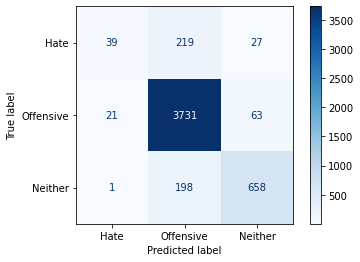

In [44]:
print(classification_report(y_test, y_predict))

labels = ["Hate", "Offensive", "Neither"]
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

Generally, the recall value will be looked at, since it provides weighted results, focusing more on the correct classified Tweets in relation with the missed ones.
In the heatmap above the classification results are visualized. The majority of the Offensive and Neither Tweets are correctly classified, however only very few Hate Speech Tweets. 

## Naive Bayes
The second classifier tested is the Naive Bayes.
After changing the datastructure a little, the classifier is constructed, trained and tested.

In [45]:
tfid = TfidfVectorizer(lowercase=False)
x_train_vec_nn = tfid.fit_transform(X_train)

In [46]:
x_train_vec_nn

<19826x17874 sparse matrix of type '<class 'numpy.float64'>'
	with 147811 stored elements in Compressed Sparse Row format>

In [47]:
#If fit_prior = False, strong overfitting in class "Hate"
nb = MultinomialNB(alpha=0, fit_prior=True)
nb.fit(x_train_vec_nn, y_train)  

/Users/kpauler/opt/anaconda3/envs/env_TextMiningTimeSeriesAnalysi/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


MultinomialNB(alpha=0)

In [48]:
y_predict = nb.predict(x_test_vec)

              precision    recall  f1-score   support

           0       0.40      0.09      0.15       285
           1       0.84      0.95      0.89      3815
           2       0.67      0.44      0.53       857

    accuracy                           0.81      4957
   macro avg       0.64      0.49      0.52      4957
weighted avg       0.78      0.81      0.79      4957



<Figure size 216x216 with 0 Axes>

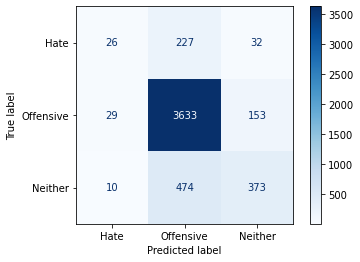

In [49]:
print(classification_report(y_test,y_predict))
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

Generally, Naive Bayes has classified less Tweets correctly for all the 3 classes, compared to Logistic Regression. Thus, so far the Logistic Regression model has performed best.

## Random Forest
As third classifier we have tested a Random Forest model. Like before the classifier is constructed, then trained and tested.

In [50]:
#If n_esimators higher --> lower recall value for Hate Speech
rfc = RandomForestClassifier(n_estimators = 3, criterion="gini", class_weight=weights, n_jobs = 24)

rfcModel = rfc.fit(x_train_vec, y_train)

In [51]:
pred = rfcModel.predict(x_test_vec)

              precision    recall  f1-score   support

           0       0.38      0.28      0.32       285
           1       0.90      0.94      0.92      3815
           2       0.79      0.72      0.75       857

    accuracy                           0.86      4957
   macro avg       0.69      0.65      0.66      4957
weighted avg       0.85      0.86      0.86      4957



<Figure size 216x216 with 0 Axes>

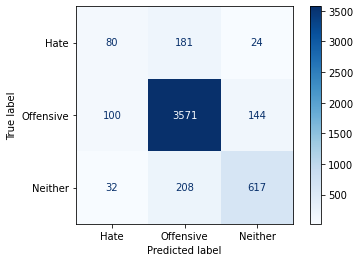

In [52]:
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

The Random Forest performed a little less well for the classes of Offensive and Neither, however classified by far more Hate Speech Tweets correctly, which is the point of focus. Thus, so far the Random Forest classifier performed best for our purpose. 

## Data for Neural Networks
As next classifiers we have tested some neural networks.
In order to train these, the data format has to be slightly altered.

In [53]:
train_tweet = X_train
test_tweet = X_test

tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_tweet)
train_tweet = tokenizer.texts_to_sequences(train_tweet)
test_tweet = tokenizer.texts_to_sequences(test_tweet)

#Not every Tweet has the same legnth. The longest Tweet defines the size of the dataframe. 
#Every Tweet, which is shorter, gets paddings in the empty cells
train_tweet = pad_sequences(train_tweet, maxlen=27)
test_tweet = pad_sequences(test_tweet, maxlen=27)

For classification purposes, the target data is refactored: While it previously was a single number (0,1,2), it now is an array with a length of three, where each element represents one class (hate, offensive, neither).

In [54]:
#The LabelEncoder ist used to encode the target labels with values between 0 and n-1 classes
#Therefore it is only used on the y values (labels)
encoder = LabelEncoder()

y_train_categorical = encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train) 

y_test_categorical = encoder.fit_transform(y_test)
y_test_categorical = to_categorical(y_test) 

In [55]:
#Here, some generall parameters for the networks are defined, 
#such as the amount of training epochs, early stopping and the learning rate changes
epoch = 50
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.7)

callbacks=[earlyStop]

## Dense Neural Network

Here the first model is defined.
A function containing the model is created. 
Afterwards the Input and Output Layer as well as the ones in between with all the parameters are defined.
Afterwards the model is trained with the predefined parameters from above and then tested. 

In [56]:
def model_1():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 256, input_length = 27))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_1 = model_1()

history_model_1 = train_model_1.fit(
           train_tweet,
           y_train_categorical,
           validation_data=(test_tweet,y_test_categorical),
           epochs= epoch,
           shuffle=True,
           callbacks=callbacks)

2021-12-29 20:24:04.834525: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
620/620 [==============================] - 38s 60ms/step - loss: 0.4040 - accuracy: 0.8614 - val_loss: 0.3431 - val_accuracy: 0.8941
Epoch 2/50
620/620 [==============================] - 37s 60ms/step - loss: 0.2975 - accuracy: 0.9018 - val_loss: 0.3046 - val_accuracy: 0.8890
Epoch 3/50
620/620 [==============================] - 36s 58ms/step - loss: 0.2325 - accuracy: 0.9224 - val_loss: 0.3168 - val_accuracy: 0.8927
Epoch 4/50
620/620 [==============================] - 37s 60ms/step - loss: 0.1782 - accuracy: 0.9391 - val_loss: 0.3445 - val_accuracy: 0.8923
Epoch 5/50
620/620 [==============================] - 40s 65ms/step - loss: 0.1392 - accuracy: 0.9527 - val_loss: 0.3778 - val_accuracy: 0.8812
Epoch 6/50
620/620 [==============================] - 36s 58ms/step - loss: 0.1134 - accuracy: 0.9624 - val_loss: 0.4092 - val_accuracy: 0.8824
Epoch 7/50
620/620 [==============================] - 40s 65ms/step - loss: 0.0939 - accuracy: 0.9678 - val_loss: 0.4745 - val_accuracy:

To extract the class of the prediction values, a function transforms the place of the highest number into an integer value. Example: If the highest number is at the beginning of the prediction array, the following function will return 0 for this instance.

In [57]:
predictions = train_model_1.predict(test_tweet)

def checkPrediction(pred):
    cleaned_prediction = []
    biggest_number = 0
    to_insert = 0
    for element in pred:
        for count in range(len(element)):
            if element[count] > biggest_number:
                biggest_number = element[count]
                to_insert = count
        biggest_number = 0
        cleaned_prediction.append(to_insert)
        to_insert = 0
    return cleaned_prediction

pred_cleaned = checkPrediction(predictions)
y_test_cleaned = checkPrediction(y_test_categorical)

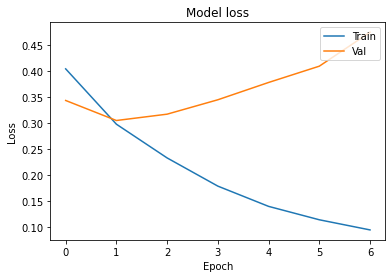

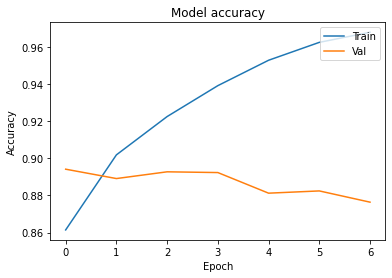

In [58]:
#The accuracy and loss curves are visualized based on the epochs
#This helps to see if the model learned long enough and what parameters we should adjust 
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.43      0.34      0.38       285
           1       0.94      0.93      0.93      3815
           2       0.81      0.90      0.85       857

    accuracy                           0.89      4957
   macro avg       0.72      0.72      0.72      4957
weighted avg       0.89      0.89      0.89      4957



<Figure size 216x216 with 0 Axes>

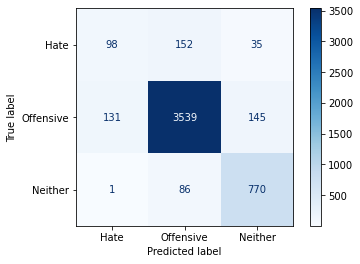

In [59]:
print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

This model achieved the highest recall values for all the three clases so far. However, we try to adjust some parameters in order to achieve even better classification results.

In the following model, additional paramters are added, like the class_weights or additional dropouts. 

In [60]:
def model_2():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Dense(256, activation='tanh'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(128, activation='tanh'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_2 = model_2()
history_model_2 = train_model_2.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs= epoch,
                   shuffle=True,
                   callbacks=callbacks)

Epoch 1/50
496/496 [==============================] - 18s 35ms/step - loss: 0.9885 - accuracy: 0.4897 - val_loss: 0.7210 - val_accuracy: 0.7110
Epoch 2/50
496/496 [==============================] - 19s 37ms/step - loss: 0.6255 - accuracy: 0.7431 - val_loss: 0.5750 - val_accuracy: 0.7769
Epoch 3/50
496/496 [==============================] - 18s 37ms/step - loss: 0.4167 - accuracy: 0.8231 - val_loss: 0.6554 - val_accuracy: 0.7587
Epoch 4/50
496/496 [==============================] - 19s 39ms/step - loss: 0.3177 - accuracy: 0.8605 - val_loss: 0.7483 - val_accuracy: 0.7390
Epoch 5/50
496/496 [==============================] - 16s 32ms/step - loss: 0.2868 - accuracy: 0.8737 - val_loss: 0.6814 - val_accuracy: 0.7705
Epoch 6/50
496/496 [==============================] - 16s 33ms/step - loss: 0.2681 - accuracy: 0.8843 - val_loss: 0.7363 - val_accuracy: 0.7668
Epoch 7/50
496/496 [==============================] - 14s 29ms/step - loss: 0.2594 - accuracy: 0.8891 - val_loss: 0.7022 - val_accuracy:

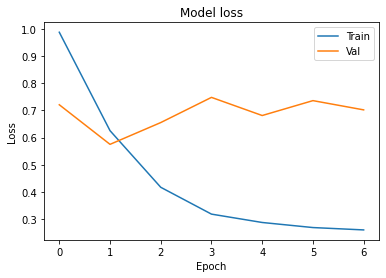

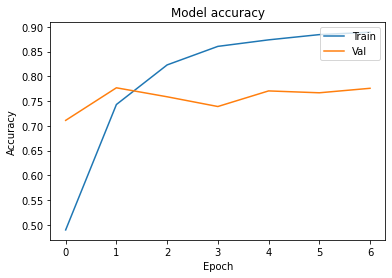

In [61]:
#The accuracy and loss curves are visualized based on the epochs
#This helps to see if the model learned long enough and what parameters we should adjust 
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.23      0.60      0.33       285
           1       0.95      0.81      0.87      3815
           2       0.74      0.82      0.78       857

    accuracy                           0.80      4957
   macro avg       0.64      0.74      0.66      4957
weighted avg       0.87      0.80      0.83      4957



<Figure size 216x216 with 0 Axes>

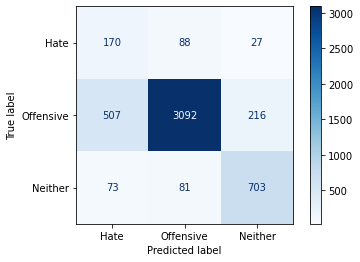

In [62]:
predictions = train_model_2.predict(test_tweet)
pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

The network performed less well for the Offensive and Neither class, however by far classified the most Hate Speech Tweets correctly.
Following some additional models will be tested, which have different hyperparameter, in order to find the best performing model. 

In [63]:
def model_3():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_3 = model_3()
history_model_3 = train_model_3.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs=epoch,
                   shuffle=True,
                   callbacks=callbacks)

Epoch 1/50
496/496 [==============================] - 14s 27ms/step - loss: 0.8528 - accuracy: 0.6270 - val_loss: 0.6511 - val_accuracy: 0.8570
Epoch 2/50
496/496 [==============================] - 12s 25ms/step - loss: 0.5377 - accuracy: 0.7837 - val_loss: 0.5450 - val_accuracy: 0.8172
Epoch 3/50
496/496 [==============================] - 13s 26ms/step - loss: 0.3586 - accuracy: 0.8472 - val_loss: 0.6035 - val_accuracy: 0.7902
Epoch 4/50
496/496 [==============================] - 13s 26ms/step - loss: 0.2489 - accuracy: 0.8901 - val_loss: 0.5168 - val_accuracy: 0.8275
Epoch 5/50
496/496 [==============================] - 13s 25ms/step - loss: 0.1917 - accuracy: 0.9110 - val_loss: 0.6903 - val_accuracy: 0.7832
Epoch 6/50
496/496 [==============================] - 13s 26ms/step - loss: 0.1446 - accuracy: 0.9299 - val_loss: 0.6366 - val_accuracy: 0.8114
Epoch 7/50
496/496 [==============================] - 13s 27ms/step - loss: 0.1138 - accuracy: 0.9454 - val_loss: 0.6500 - val_accuracy:

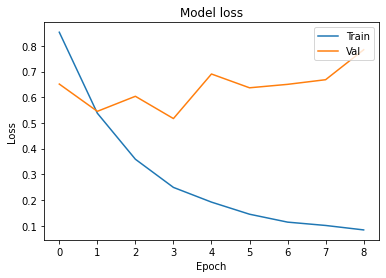

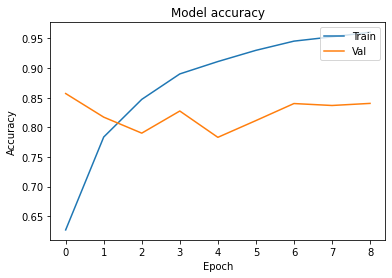

In [64]:
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.27      0.58      0.37       285
           1       0.94      0.85      0.89      3815
           2       0.79      0.83      0.81       857

    accuracy                           0.83      4957
   macro avg       0.66      0.75      0.69      4957
weighted avg       0.88      0.83      0.85      4957



<Figure size 216x216 with 0 Axes>

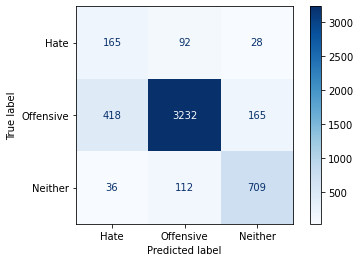

In [65]:
predictions = train_model_3.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

In [66]:
def model_4():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7))    
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7)) 
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
    return model

train_model_4 = model_4()
history_model_4 = train_model_4.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs= epoch,
                   shuffle=True,
                   callbacks=callbacks)

Epoch 1/50
496/496 [==============================] - 11s 20ms/step - loss: 1.3012 - accuracy: 0.3353 - val_loss: 1.0889 - val_accuracy: 0.3424
Epoch 2/50
496/496 [==============================] - 8s 16ms/step - loss: 1.1856 - accuracy: 0.3723 - val_loss: 0.9858 - val_accuracy: 0.5406
Epoch 3/50
496/496 [==============================] - 8s 16ms/step - loss: 1.0615 - accuracy: 0.5028 - val_loss: 0.6994 - val_accuracy: 0.7564
Epoch 4/50
496/496 [==============================] - 8s 16ms/step - loss: 0.9205 - accuracy: 0.6090 - val_loss: 0.5626 - val_accuracy: 0.7968
Epoch 5/50
496/496 [==============================] - 8s 16ms/step - loss: 0.8026 - accuracy: 0.6576 - val_loss: 0.6146 - val_accuracy: 0.7653
Epoch 6/50
496/496 [==============================] - 8s 17ms/step - loss: 0.7162 - accuracy: 0.6874 - val_loss: 0.5492 - val_accuracy: 0.7842
Epoch 7/50
496/496 [==============================] - 7s 15ms/step - loss: 0.6509 - accuracy: 0.7197 - val_loss: 0.5692 - val_accuracy: 0.785

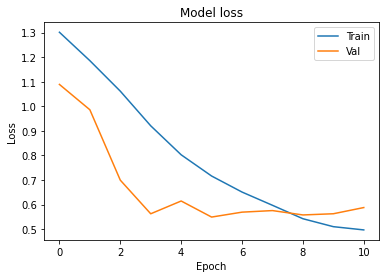

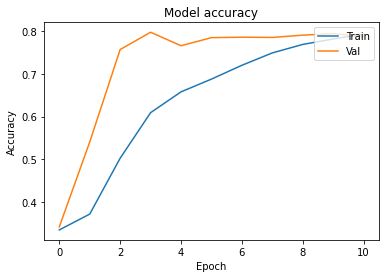

In [67]:
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_4.history['accuracy'])
plt.plot(history_model_4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.20      0.67      0.31       285
           1       0.97      0.80      0.87      3815
           2       0.79      0.80      0.80       857

    accuracy                           0.79      4957
   macro avg       0.65      0.76      0.66      4957
weighted avg       0.89      0.79      0.83      4957



<Figure size 216x216 with 0 Axes>

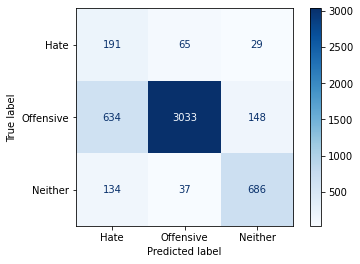

In [68]:
predictions = train_model_4.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

In generall have the neural networks performed best according to the recall value. Hereby was the model_3 in the test run the most accurate one in the overall performance.
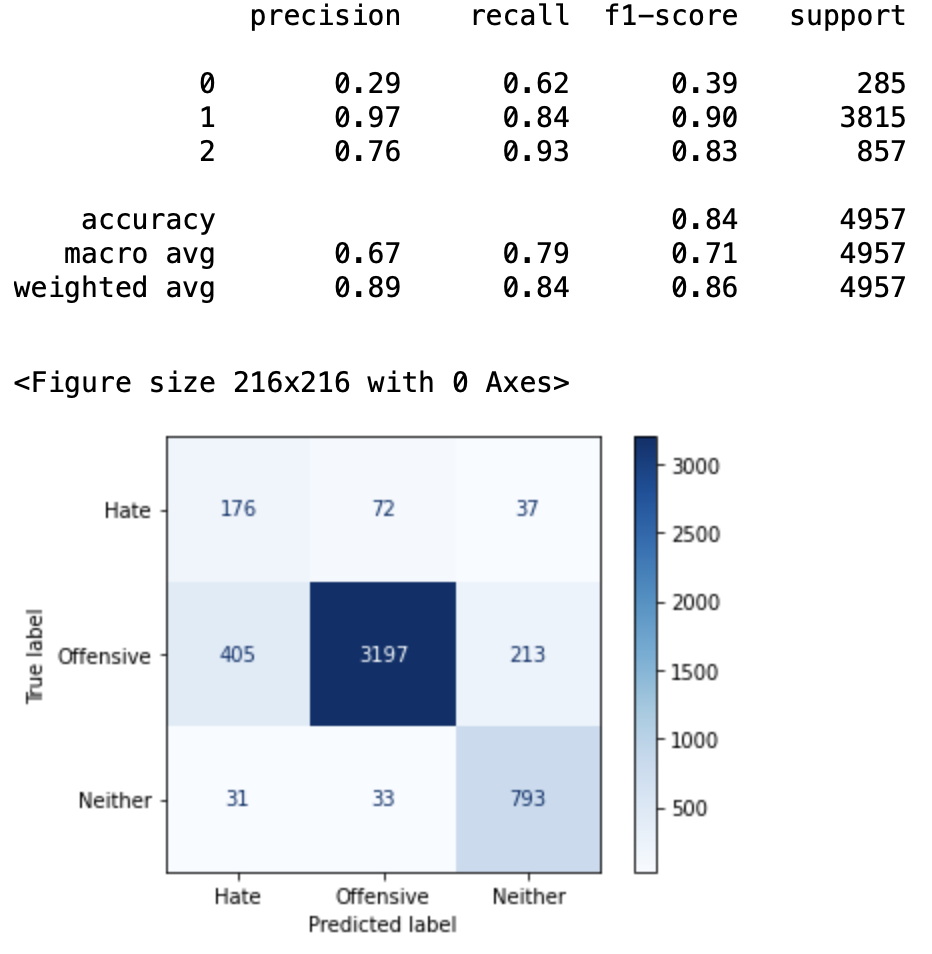

In [69]:
#Here again an overview of the structure of the model 3
#We can observe that it has almost 2.4 million trainable parameters, indicating how complex the classification task
#actually is
train_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 27, 128)           2292352   
                                                                 
 conv1d (Conv1D)             (None, 23, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                      

The best performing classifier will subesquently be placed into a Twitter bot to perform the classification on real Tweets. Afterwards the Tweets will be manually classified and compared with the results of the notebook, in order to derive general insights. 